In [1]:
from UNETPyTorch.UnetModel import GeneralUNETModel
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Create the output layer
class PoolSoftmaxOutput(nn.Module):
    def __init__(self, in_channels, out_classes):
        super().__init__()
        # 1x1 Convolution to go from UNET channels to MNIST classes
        self.final_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_classes, kernel_size=1)

    def forward(self, unet_output):
        conv_output = self.final_conv(unet_output)

        # Global average pooling
        pooled_output = F.adaptive_avg_pool2d(conv_output, (1, 1))

        # Flatten down to 1 dimension
        class_output = pooled_output.view(pooled_output.size(0), -1)

        # Return the raw values of each class
        return class_output

In [3]:
# Specify normalization transformation for data
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resizes to a power of two for simple handling
    transforms.ToTensor(),  # Converts images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images (mean, std)
])

# Load MNIST dataset (training and test sets)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader to load data in batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Text(0.5, 1.0, 'Label: 5')

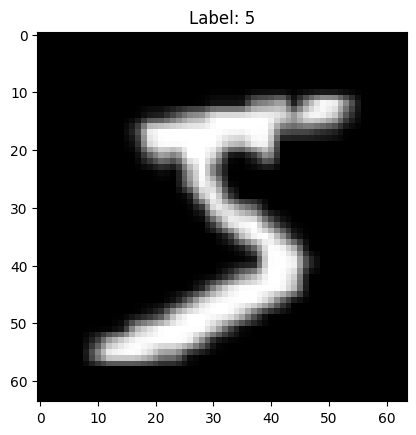

In [4]:
# Visualize a sample image to ensure it's loaded correctly
first_image, first_label = train_dataset[0]
plt.imshow(first_image.squeeze(), cmap='gray')  # MNIST is single-channel, using cmap='gray'
plt.title(f"Label: {first_label}")

In [6]:
# Create the model to use
dimensions = 2
channels = 1
conv_filters = [64, 128, 256, 512]
mnist_classes = 10
my_out_layer = PoolSoftmaxOutput(in_channels=conv_filters[0], out_classes=mnist_classes)
optim_loss_rate = 0.002
mnist_model = GeneralUNETModel(
    name='unet_attention_mnist_model', in_dimensions=dimensions, in_channels=channels, conv_channels=conv_filters,
    out_layer=my_out_layer, use_up_atten=True, use_dconv_bn=True, use_dconv_relu=True, loss_rate=optim_loss_rate
)
print(mnist_model)

unet_attention_mnist_model
2-Dimension UNET
------------------------

UNETTwo(
  (down_samplers): ModuleList(
    (0): DownSampleTwo(
      (conv): DoubleConvTwo(
        (first_conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (sec_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownSampleTwo(
      (conv): DoubleConvTwo(
        (first_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, aff

In [7]:
# Train the model
epoch_count = 1
print_interval = max(1, len(train_loader) // 100)
loss_module = nn.CrossEntropyLoss()
model_train_stats = mnist_model.train_model(
    train_loader=train_loader, epochs=epoch_count, loss_func=loss_module, print_interval=print_interval
)

Cuda availability status: True
New best loss score: 2.2849457263946533
Saving epoch model...
New best loss score: 2.2757701873779297
Saving epoch model...
New best loss score: 2.2005226612091064
Saving epoch model...
New best loss score: 2.18369197845459
Saving epoch model...
New best loss score: 2.112861394882202
Saving epoch model...
New best loss score: 2.075141668319702
Saving epoch model...
New best loss score: 1.8944629430770874
Saving epoch model...
New best loss score: 1.8708752393722534
Saving epoch model...
Epoch: 1, Batch: 18, Loss: 2.0720
New best loss score: 1.7609981298446655
Saving epoch model...
New best loss score: 1.7407251596450806
Saving epoch model...
New best loss score: 1.6734188795089722
Saving epoch model...
New best loss score: 1.6105531454086304
Saving epoch model...
Epoch: 1, Batch: 36, Loss: 1.5701
New best loss score: 1.5700887441635132
Saving epoch model...
New best loss score: 1.5507533550262451
Saving epoch model...
New best loss score: 1.54623246192932

In [8]:
model_train_stats

,epoch,batch,loss
0,1,1,2.284946
1,1,2,2.316971
2,1,3,2.275770
3,1,4,2.200523
4,1,5,2.183692
...,...,...,...
1870,1,1871,0.131327
1871,1,1872,0.069028
1872,1,1873,0.122058
1873,1,1874,0.030505
